In [1]:
# utils
import scipy
import skbio
import qiime2
import itertools
import numpy as np 
import pandas as pd
import scipy.stats as ss
from qiime2.plugins import diversity, feature_table
from scipy.spatial import ConvexHull
# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

In [2]:
tab = qiime2.Artifact.load('../data/processed-data/table.qza')
tree = qiime2.Artifact.load('../data/processed-data/tree.qza')
metadata = qiime2.Metadata.load('../data/processed-data/metadata.tsv').to_dataframe()


In [3]:
sub_counts = metadata.groupby(['mom_baby','body_site_corrected',
                               'date_sampling_category_days_continuous']).agg({'subjectid_unique':'count'})
sub_counts = sub_counts.reset_index()
type_ = {}
keep_ = {'Baby':['Feces','Mouth','Forearm'],
         'Mom':['Feces','Mouth','Forearm','Right_Areola','Nose','Vagina']}
for k_, sub_counts_ in sub_counts.groupby('mom_baby'):
    type_[k_] = sub_counts_.pivot(index='date_sampling_category_days_continuous',
                                columns='body_site_corrected',
                                values='subjectid_unique').fillna(0)[keep_[k_]]
count_time = pd.concat(type_, axis=1)
count_time = count_time[count_time.index <= 360]
count_time.index = count_time.index.astype(int)
count_time = count_time.fillna(0)
count_time = count_time.rename({'Feces':'Fecal','Mouth':'Oral',
                                'Right_Forearm':'Skin',
                                'Right_Areola':'Right Areola'}, axis=1)
count_time.index.names = ['Time (day)']
count_time.columns.names = ['','']
count_time = count_time.astype(int)
count_time.to_csv('../results/Extended-Data-Table-2.csv', sep='\t')
count_time


Baby                Mom                                      
           Fecal Oral Forearm Fecal Oral Forearm Right Areola Nose Vagina
Time (day)                                                               
-120           0    0       0     0    0       0            0    0     20
-90            0    0       0     1    2       0            2    2     17
-60            0    0       0     7   11       0           11   11     16
-30            0    0       0    24   27       0           26   27     60
-1             0    0       0     1   11       0            9    1     14
 0            91   72       6    35   75       6           68   48     81
 1            87   82       7    30   70       7           70   52     59
 2           100   89       6    62   78       6           80   54     72
 7           148  102      16   103   93      18           80   66     80
 14          122  109      19    78   81      19           74   57     69
 21           90   87       0    49   64       0           70   39     71
 30          197  108      20    86   83      20           72   61     86
 60          141   73      20    48   48      20           46   30     55
 90          101   51       0    35   30       0           33   11     38
 120          97   63      20    42   46      19           36   28     35
 150          86   42       0    27   28       0           27    9     32
 180          97   55      19    46   40      19           33   25     32
 210          69   38       0    21   22       0           34    8     32
 240          71   36       0    20   25       0           36    8     31
 270          67   29       0    18   20       0           37    6     31
 300          68   34       0    16   20       0           35    5     28
 330          66   32       0    20   22       0           34    6     29
 360          82   54      18    39   36      19           34   25     26

In [4]:
uw = qiime2.Artifact.load('../data/convex-hull/uw_rare5_distance_matrix.qza')
skuw = uw.view(skbio.DistanceMatrix)
# split into per-body site
metadata = metadata.loc[list(skuw.ids)]
site_pcs = {}
all_ids = set()
for body_site in {'Feces', 'Right_Forearm', 'Mouth'}:
    subset = metadata[metadata.body_site_corrected == body_site]
    subset_uw = skuw.filter(list(subset.index))
    subset_uw_q2 = qiime2.Artifact.import_data('DistanceMatrix', subset_uw)
    subset_pc, = diversity.actions.pcoa(subset_uw_q2, number_of_dimensions=5)
    subset_pc.save('../data/convex-hull/%s_unweighted_unifrac_pcoa.qza' % body_site)
    site_pcs[body_site] = subset_pc.view(skbio.OrdinationResults)
    all_ids.update(set(subset.index))
md = metadata.loc[list(all_ids)]


In [5]:
# per-body site *from saved files*
site_pcs = {}
all_ids = set()
for body_site in {'Feces', 'Right_Forearm', 'Mouth'}:
    subset = metadata[metadata.body_site_corrected == body_site]
    subset_pc = qiime2.Artifact.load('../data/convex-hull/%s_unweighted_unifrac_pcoa.qza' % body_site)
    subset_ord = subset_pc.view(skbio.OrdinationResults)
    site_pcs[body_site] = subset_ord
    all_ids.update(set(subset.index)&set(subset_ord.samples.index))
md = metadata.loc[list(all_ids)]
md.body_site_corrected.value_counts()


Feces            2555
Mouth            1926
Right_Forearm    1169
Name: body_site_corrected, dtype: int64

In [6]:
ndims = 3
site_person_ch = []
for site, site_grp in md.groupby('body_site_corrected'):
    print(site)
    if site not in site_pcs:
        continue
    pc = site_pcs[site]

    assert set(md.index).issuperset(set(pc.samples.index))
    for person, person_grp in site_grp.groupby('subjectid_unique'):
        mom_baby = person_grp.mom_baby[0]
        birth_mode = person_grp.birth_mode_ms[0]
        
        if mom_baby == 'Mom':
            birth_mode = 'Mom'
            
        if birth_mode in ('CSself', 'CSseed'):
            birth_mode = 'CSseed'
            
        n_timepoints = len(person_grp)
        
        if n_timepoints <= (ndims ):
            continue
        
        coords = pc.samples.loc[person_grp.index].values[:, :ndims]
        ch = ConvexHull(coords)
        site_person_ch.append([site, person, mom_baby, birth_mode, n_timepoints, ch.volume, ch.area])
    
site_person_ch = pd.DataFrame(site_person_ch, 
                              columns=['body_site', 'subjectid_unique', 'mom_baby', 'birth_mode', 
                                       'n_timepoints', 'convexhull_volume', 'convexhull_area'])


Feces
Mouth
Right_Forearm


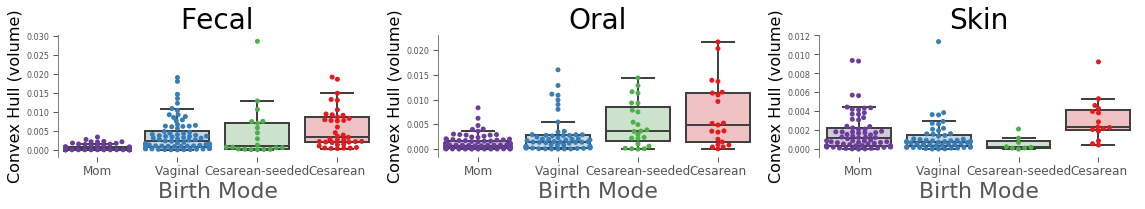

In [7]:
# colors
camp_ = {'Mom':'#6a3d9a',
         'Vaginal':'#377eb8',
         'Cesarean-seeded':'#4daf4a',
         'Cesarean':'#e41a1c'}
replace_ = {'Mom':'Mom',
           'Vag':'Vaginal',
           'CS':'Cesarean',
           'CSseed':'Cesarean-seeded'}
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': .1}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 8

fig, axn = plt.subplots(1,3, figsize=(16, 3))

stypes = ['Feces','Mouth','Right_Forearm']
stypes_map = {'Feces':'Fecal',
              'Mouth':'Oral',
              'Right_Forearm':'Skin'}
for stype_, ax in zip(stypes, axn.flatten()):
    
    site_person_ch_tmp = site_person_ch[site_person_ch.body_site.isin([stype_])].copy()
    site_person_ch_tmp['bmode'] = site_person_ch_tmp.birth_mode.replace(replace_)
    sns.boxplot(data=site_person_ch_tmp,
                y='convexhull_volume',
                x='bmode',
                order=['Mom', 'Vaginal', 'Cesarean-seeded', 'Cesarean'],
                palette=camp_, ax=ax, showfliers=False)
    sns.swarmplot(data=site_person_ch_tmp,
                y='convexhull_volume',
                x='bmode',
                order=['Mom', 'Vaginal', 'Cesarean-seeded', 'Cesarean'],
                palette=camp_, ax=ax, dodge=True)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    ax.set_ylabel('Convex Hull (volume)',
                  fontsize=16,
                  color='black')
    ax.set_xlabel('Birth Mode',
                  fontsize=22)
    ax.set_title(stypes_map[stype_], fontsize=28)
    #ax.legend_.remove()
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')


plt.tight_layout()

#save
plt.savefig('../results/Figure-1b.pdf',dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [8]:

stats_df = {}
for stype_ in stypes:
    # add stat annots
    order = ['Mom', 'Vag', 'CSseed', 'CS']
    site_person_ch_tmp = site_person_ch[site_person_ch.body_site.isin([stype_])].copy()
    order_map = {i:v for v, i in enumerate(order)}
    order_map = {v:tuple(order_map[v_] for v_ in v)
                 for v in list(itertools.combinations(order, 2))}
    order_stats = {k:list(ss.mannwhitneyu(site_person_ch_tmp[site_person_ch_tmp.birth_mode.isin([k[0]])].convexhull_volume,
                                     site_person_ch_tmp[site_person_ch_tmp.birth_mode.isin([k[1]])].convexhull_volume))
                   for k, v in order_map.items()}
    stat_tmp = pd.DataFrame(order_stats, ['test-stat','P']).T
    stats_df[stype_] = stat_tmp

stats_df = pd.concat(stats_df).reset_index()
stats_df.columns = ['body_type','g1','g2','test-stat','P']
stats_df['compare'] = stats_df['g1'] + ' vs. ' + stats_df['g2'] 
stats_df = stats_df.drop(['g1','g2'], axis=1)
stats_df = stats_df[['body_type','compare','test-stat','P']]
stats_df['P'] = stats_df['P'] * len(list(itertools.combinations(order, 2)))
stats_df['P'] = [str(v)[:4] + str(v)[str(v).index('e'):] if 'e' in str(v) else str(v) 
                 if v < .0001 else round(v, 3) for v in stats_df.P]
stats_df['test-stat'] = stats_df['test-stat'].astype(int)
stats_df.to_csv('../results/Extended-Data-Table-4.csv')
stats_df


,body_type,compare,test-stat,P
0,Feces,Mom vs. Vag,999,2.96e-13
1,Feces,Mom vs. CSseed,390,0.001
2,Feces,Mom vs. CS,215,2.19e-13
3,Feces,Vag vs. CSseed,733,1.7
4,Feces,Vag vs. CS,1138,0.084
5,Feces,CSseed vs. CS,263,0.17
6,Mouth,Mom vs. Vag,1946,0.015
7,Mouth,Mom vs. CSseed,484,0
8,Mouth,Mom vs. CS,348,1.13e-05
9,Mouth,Vag vs. CSseed,420,0.037
